# 제주 관광객 소비패턴 변화 분석(BC카드)
## 1. Definition
### Overview
2014년~2016년 제주도 내 내국인 관광객의 카드 소비 패턴 분석을 통해서 어떠한 상권에서 어떠한 소비를 많이 하는지에 대해 분석하고, 이를 통해 데이터가 주어지면 어떠한 상권에서 어떠한 업종이 유망할 지에 대한 모델을 만들고자 한다.
### Metric
## 2. Data Exploration
### import library

In [272]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import os, random, time, gc, warnings

from tqdm import tqdm_notebook

import lightgbm as lgbm
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

# from catboost import CatBoostRegressor
from sklearn.feature_selection import RFECV


from sklearn.cluster import KMeans

from datetime import datetime

from math import sqrt

import folium
from folium import Marker, Icon, CircleMarker
from folium.plugins import MarkerCluster

from pdpbox import pdp, info_plots
import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

%matplotlib inline

In [3]:
os.listdir('./input/')

['domestic_consumption_data.csv',
 'market_consumption_data.csv',
 'reference_data',
 'supplementary_data']

### Load Dataset

In [161]:
data = pd.read_csv('./input/domestic_consumption_data.csv',parse_dates=['기준년월','데이터기준일자'],encoding='ANSI')
data.head()

,기준년월,관광객 유형,제주 대분류,제주 중분류,업종명,성별,연령대별,카드이용금액,카드이용건수,건당이용금액,데이터기준일자
0,2014-09-01,내국인 관광객,서귀포시,대륜동,농축수산품,여,50대,14434000,67,215433,2017-02-16
1,2014-09-01,내국인 관광객,서귀포시,대륜동,농축수산품,남,50대,15119000,72,209986,2017-02-16
2,2014-09-01,내국인 관광객,서귀포시,대륜동,농축수산품,여,40대,7609500,41,185598,2017-02-16
3,2014-09-01,내국인 관광객,서귀포시,남원읍,농축수산품,남,50대,7092500,40,177313,2017-02-16
4,2014-09-01,내국인 관광객,서귀포시,대륜동,농축수산품,남,40대,9098500,59,154212,2017-02-16


In [5]:
data.columns

Index(['기준년월', '관광객 유형', '제주 대분류', '제주 중분류', '업종명', '성별', '연령대별', ' 카드이용금액 ',
       ' 카드이용건수 ', '건당이용금액', '데이터기준일자'],
      dtype='object')

### Columns
- 기준년월 : 해당 데이터가 발생한 날짜
- 관광객 유형 : 모두 내국인 관광객으로 동일
- 제주 대분류 : 제주시, 서귀포시
- 제주 중분류 : 읍면동
- 업종명 : 업종의 종류를 나타낸다.
- 성별 : 남/여
- 연령대별 : 연령대
- 카드이용금액
- 카드이용건수
- 건당이용금액 : 카드이용금액 / 카드이용건수
- 데이터기준일자 : database가 만들어진 날짜

'데이터 기준일자'은 2017-02-16으로 모두 동일하고,  '관광객 유형'은 모두 내국인 관광객으로 동일하므로 삭제한다. 또한 column명 중 불필요한 공백은 제거한다.

In [162]:
# columns명 중 앞뒤 공백이 있는 string은 제거해준다.
data.drop(['관광객 유형','데이터기준일자'],axis=1,inplace=True)
data.rename(columns={' 카드이용금액 ':'카드이용금액',' 카드이용건수 ': '카드이용건수'},inplace=True)
data.columns

Index(['기준년월', '제주 대분류', '제주 중분류', '업종명', '성별', '연령대별', '카드이용금액', '카드이용건수',
       '건당이용금액'],
      dtype='object')

중복되는 데이터는 없다.

In [12]:
display(data.shape)
display(data.duplicated().sum())

(13146, 9)

0

### Missing Value
결측치는 없다.

In [77]:
# 한글 글꼴 설정
import matplotlib.font_manager as fm

fm.get_fontconfig_fonts()
plt.rc('font', family='Malgun Gothic')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13146 entries, 0 to 13145
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   기준년월    13146 non-null  datetime64[ns]
 1   제주 대분류  13146 non-null  object        
 2   제주 중분류  13146 non-null  object        
 3   업종명     13146 non-null  object        
 4   성별      13146 non-null  object        
 5   연령대별    13146 non-null  object        
 6   카드이용금액  13146 non-null  int64         
 7   카드이용건수  13146 non-null  int64         
 8   건당이용금액  13146 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 924.5+ KB


### 기준년월
모든 데이터들은 매월 1일자로 데이터가 기록되어있다.

In [15]:
display(print(data['기준년월'].agg(['min','max']),'\n'))
display(print(data['기준년월'].unique()))

min   2014-09-01
max   2016-08-01
Name: 기준년월, dtype: datetime64[ns] 



None

['2014-09-01T00:00:00.000000000' '2014-10-01T00:00:00.000000000'
 '2014-11-01T00:00:00.000000000' '2014-12-01T00:00:00.000000000'
 '2015-01-01T00:00:00.000000000' '2015-02-01T00:00:00.000000000'
 '2015-03-01T00:00:00.000000000' '2015-04-01T00:00:00.000000000'
 '2015-05-01T00:00:00.000000000' '2015-06-01T00:00:00.000000000'
 '2015-07-01T00:00:00.000000000' '2015-08-01T00:00:00.000000000'
 '2015-09-01T00:00:00.000000000' '2015-10-01T00:00:00.000000000'
 '2015-11-01T00:00:00.000000000' '2015-12-01T00:00:00.000000000'
 '2016-01-01T00:00:00.000000000' '2016-02-01T00:00:00.000000000'
 '2016-03-01T00:00:00.000000000' '2016-04-01T00:00:00.000000000'
 '2016-05-01T00:00:00.000000000' '2016-06-01T00:00:00.000000000'
 '2016-07-01T00:00:00.000000000' '2016-08-01T00:00:00.000000000']


None

### 제주 대분류, 제주 중분류

In [16]:
data.columns

Index(['기준년월', '제주 대분류', '제주 중분류', '업종명', '성별', '연령대별', '카드이용금액', '카드이용건수',
       '건당이용금액'],
      dtype='object')

In [17]:
city_in_jejudo = data['제주 대분류'].unique()
town_in_jejudo = data['제주 중분류'].unique()
display(print('도시의 갯수 : {}'.format(len(city_in_jejudo))))
display(print(city_in_jejudo))
display(print('동네의 갯수 : {}'.format(len(town_in_jejudo))))
display(print(town_in_jejudo))

도시의 갯수 : 2


None

['서귀포시' '제주시']


None

동네의 갯수 : 10


None

['대륜동' '남원읍' '연동' '예래동' '이도2동' '삼도2동' '용담2동' '노형동' '애월읍' '성산읍']


None

In [18]:
os.listdir('.')

['.git',
 '.idea',
 '.ipynb_checkpoints',
 'consumption pattern analysis of jeju tourist.ipynb',
 'get_position.py',
 'input',
 'jeju_town_pos',
 'NanumFontSetup_TTF_BARUNGOTHIC']

In [19]:
town_pos = pd.read_csv('./jeju_town_pos')
display(town_pos.shape)
display(town_pos)

(10, 3)

,address,latitude,longitude
0,대륜동,33.248109,126.511403
1,남원읍,33.279925,126.720650
2,연동,34.794701,126.391650
3,예래동,33.254292,126.397863
4,이도2동,33.497068,126.535275
5,삼도2동,33.511717,126.522188
6,용담2동,33.511492,126.511663
7,노형동,33.483085,126.477175
8,애월읍,33.462010,126.329488
9,성산읍,33.442135,126.911013


In [20]:
import math
# create map, 소비 데이터의 가맹점이 존재하는 지역을 지도에 표시하였다.
jeju_map_solo = folium.Map(location=[33.3617,126.5292],tiles='cartodbpositron',zoom_start=10)

# Add points to the map
mc = MarkerCluster()
for idx, row in town_pos.iterrows():
    if not math.isnan(row['longitude']) and not math.isnan(row['latitude']):
        mc.add_child(Marker([row['latitude'],row['longitude']],popup=row['address']))
jeju_map_solo.add_child(mc)

jeju_map_solo

### 업종명
중간에 불필요한 공백이 있는 data는 공백을 없애주도록 한다.

In [21]:
upjong = data['업종명'].unique()
print(f'업종의 갯수 : {len(upjong)}\n',upjong)

업종의 갯수 : 14
 ['농축수산품' '스포츠레져용품' '골프 용품' '악세 사리' '의원' '안경' '정장(여성)' '기념품 점' '기타음료식품'
 '슈퍼 마켓' '신   발' '약국' '스넥' '귀 금 속']


In [22]:
# 불필요한 공백 제거
data['업종명'] = [uj.replace(" ","") for uj in data['업종명']]
upjong = data['업종명'].unique()
upjong

array(['농축수산품', '스포츠레져용품', '골프용품', '악세사리', '의원', '안경', '정장(여성)', '기념품점',
       '기타음료식품', '슈퍼마켓', '신발', '약국', '스넥', '귀금속'], dtype=object)

### 성별

In [23]:
sex = data['성별'].unique()
print(sex)

['여' '남']


,업종명,성별,카드이용금액
7,농축수산품,남,7064962946
9,슈퍼마켓,남,6768028620
8,농축수산품,여,6027597440
10,슈퍼마켓,여,4922541593
3,기념품점,남,3997426584
4,기념품점,여,3867428411
11,스넥,남,2828188943
12,스넥,여,2632974614
13,스포츠레져용품,남,2059669368
14,스포츠레져용품,여,1353768950


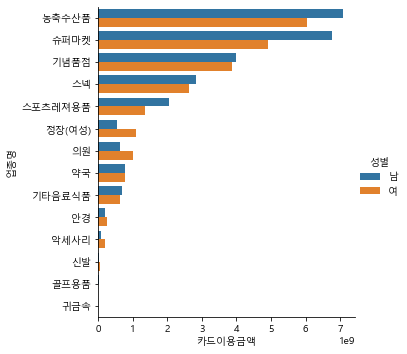

In [24]:
# 성별에 따른 각각의 업종 매출액
card_usage_amount_by_sex = data.groupby(['업종명','성별'])['카드이용금액'].sum()
cuabs = card_usage_amount_by_sex.to_frame(name="카드이용금액").reset_index().sort_values(by='카드이용금액',ascending=False)
# sns.set(rc={'figure.figsize':(80,10)})
display(cuabs)

g = sns.catplot(x='카드이용금액',y='업종명', hue='성별', data=cuabs, orient='h', kind='bar')

### 연령대별

In [21]:
age_grp = data['연령대별'].unique()
print(age_grp)

['50대' '40대' '30대' '20대']


### 카드이용금액

In [22]:
data.columns

Index(['기준년월', '제주 대분류', '제주 중분류', '업종명', '성별', '연령대별', '카드이용금액', '카드이용건수',
       '건당이용금액'],
      dtype='object')

In [23]:
card_usage_amount = data['카드이용금액']
card_usage_amount.agg(['min','max'])

min       36100
max    64277700
Name: 카드이용금액, dtype: int64

In [25]:
upjong

array(['농축수산품', '스포츠레져용품', '골프용품', '악세사리', '의원', '안경', '정장(여성)', '기념품점',
       '기타음료식품', '슈퍼마켓', '신발', '약국', '스넥', '귀금속'], dtype=object)

Text(0.5, 0.98, 'Card usage amount by industry')

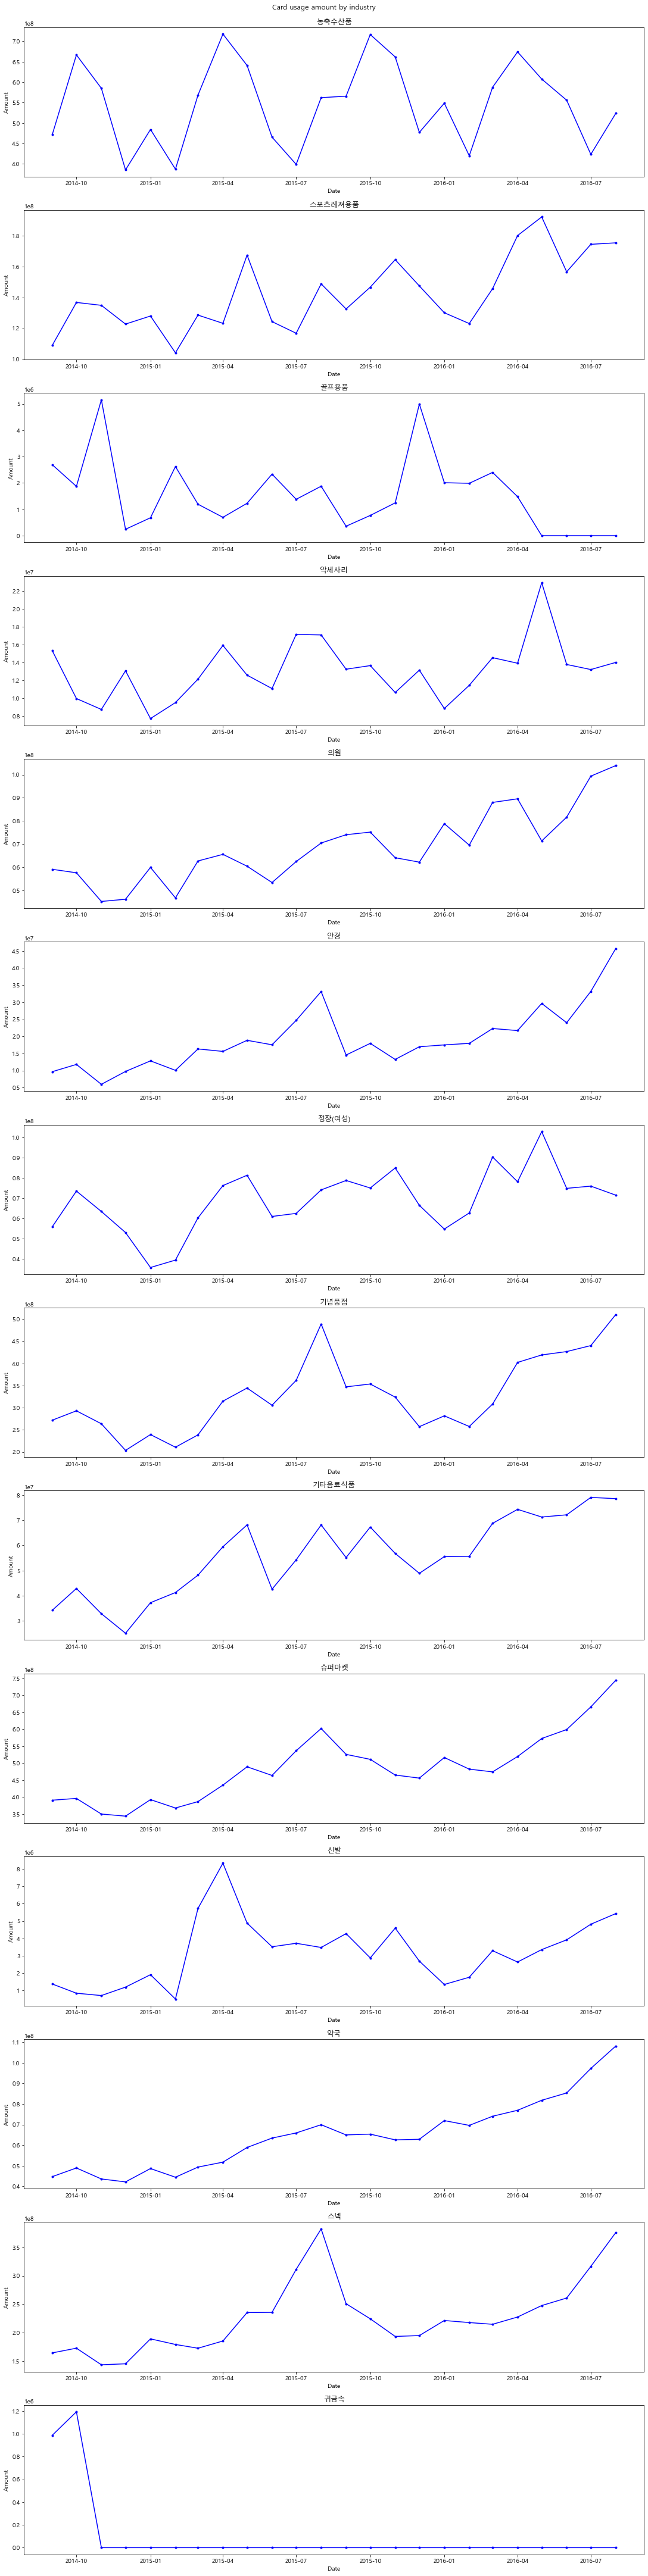

In [19]:
# 시간에 따른 업종별 카드이용금액
card_usage_amount_by_industry = data.groupby(['업종명','기준년월'])['카드이용금액'].sum()
dates = data['기준년월'].unique()
fig, axes = plt.subplots(nrows=len(upjong),figsize=(15,60),constrained_layout=True)

# 업종중 특정날짜의 데이터가 없는 경우가 있다. 따라서 특정날짜의 data를 0으로 하여 추가한다.
for idx, industry in enumerate(upjong):
    result = card_usage_amount_by_industry.loc[(industry,dates)]
    date_by_industry = result.index.get_level_values('기준년월')
    for date in dates:
        if date not in date_by_industry:
            result[(industry,date)]=0          
           
    axes[idx].plot(dates,result,color='b',marker='.')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Amount')
    axes[idx].set_title(industry)

plt.suptitle('Card usage amount by industry')

Text(0.5, 0.98, 'Number of card usage by industry')

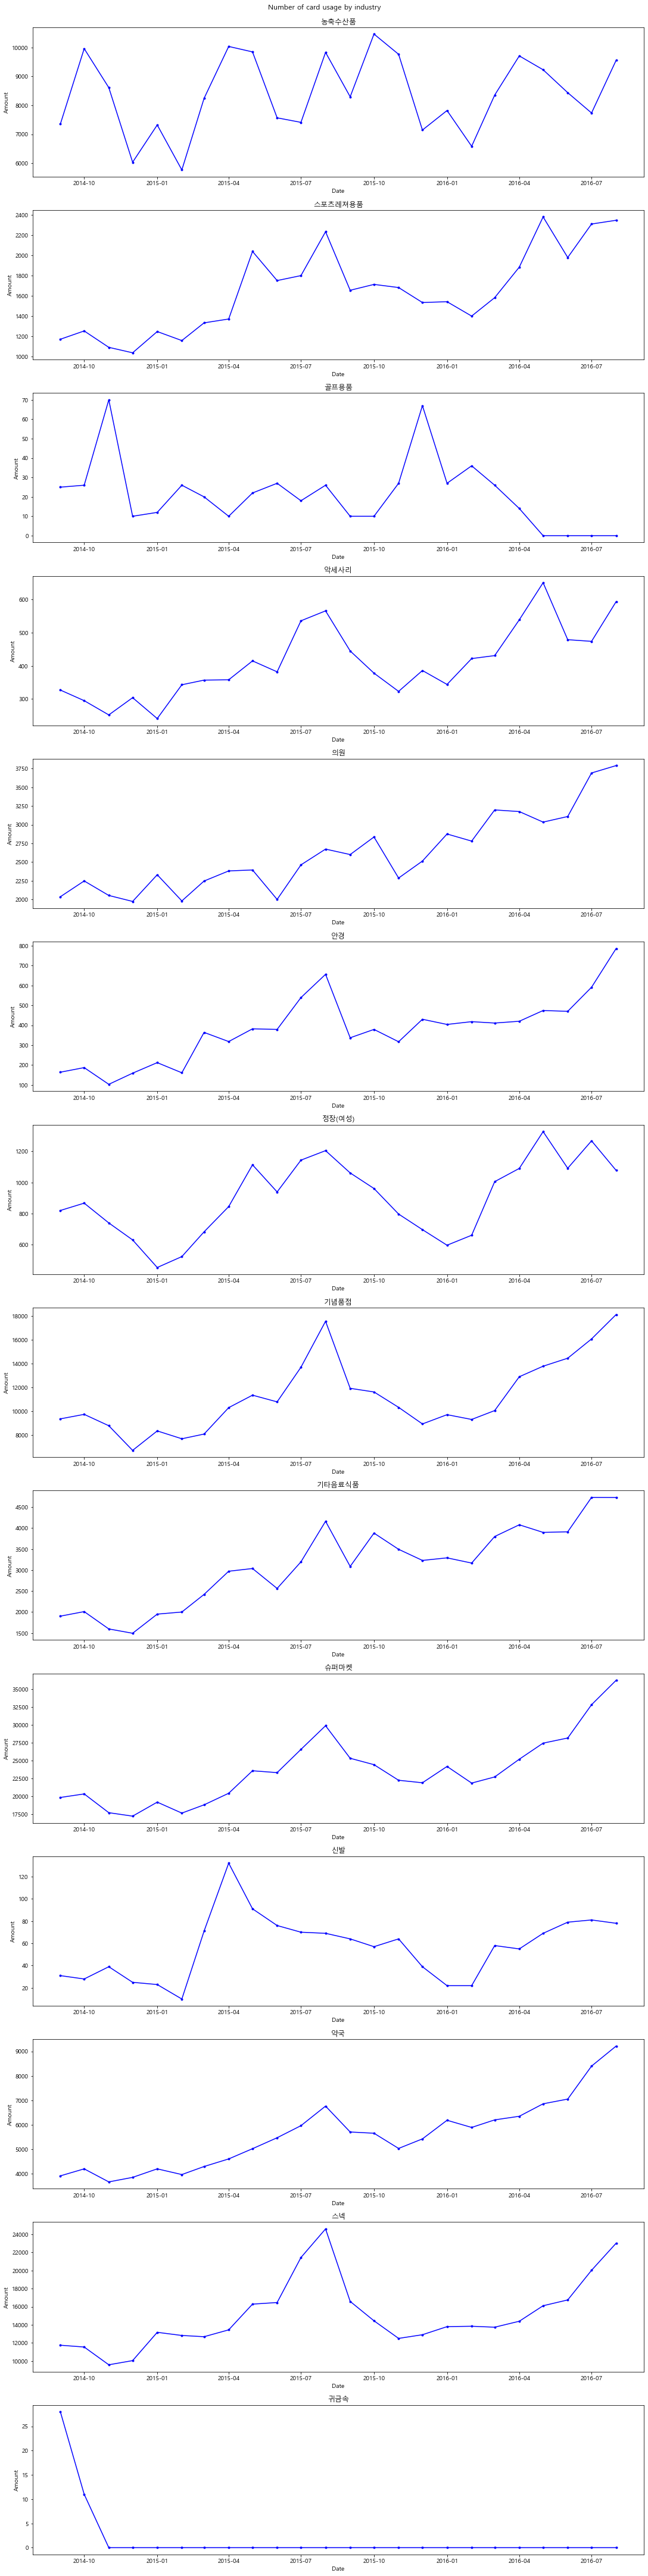

In [23]:
# 시간에 따른 업종별 카드이용건수
number_of_card_usage_by_industry = data.groupby(['업종명','기준년월'])['카드이용건수'].sum()
dates = data['기준년월'].unique()
fig, axes = plt.subplots(nrows=len(upjong),figsize=(15,60),constrained_layout=True)

# 업종중 특정날짜의 데이터가 없는 경우가 있다. 따라서 특정날짜의 data를 0으로 하여 추가한다.
for idx, industry in enumerate(upjong):
    result = number_of_card_usage_by_industry.loc[(industry,dates)]
    date_by_industry = result.index.get_level_values('기준년월')
    for date in dates:
        if date not in date_by_industry:
            result[(industry,date)]=0          
    
    axes[idx].plot(dates,result,color='b',marker='.')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Amount')
    axes[idx].set_title(industry)

plt.suptitle('Number of card usage by industry')

Text(0.5, 0.98, 'Card usage amount by town')

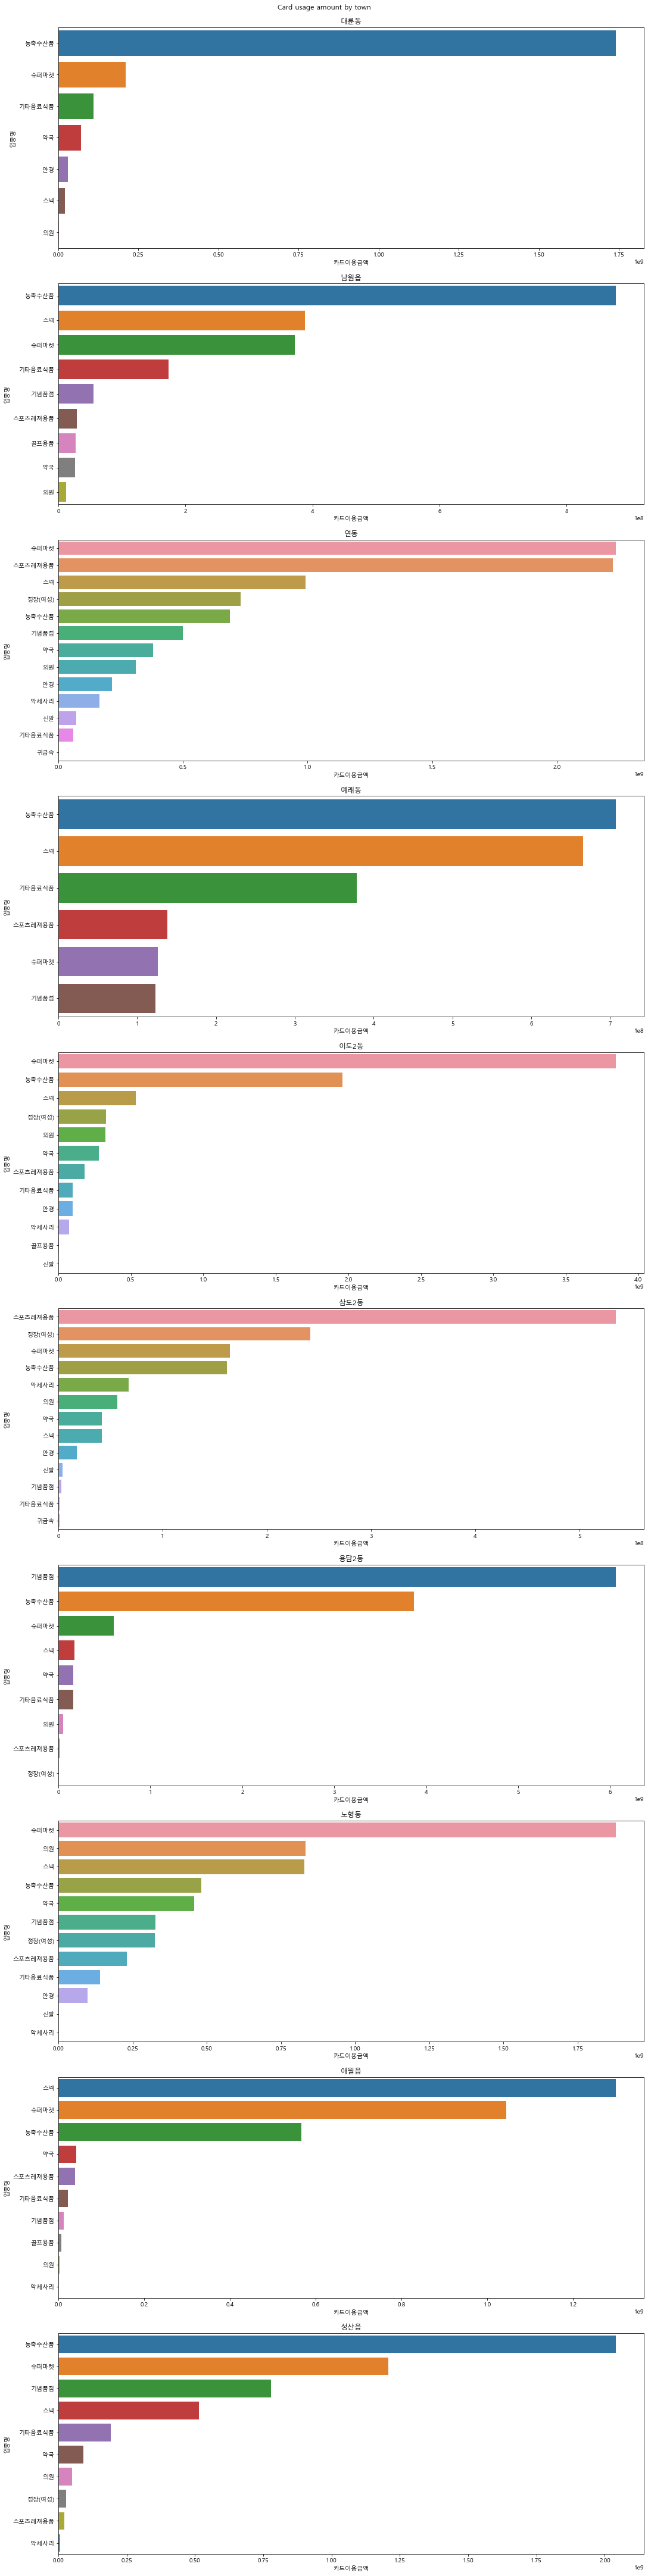

In [26]:
# 지역별로 소비된 업종 분포(카드사용금액 기준)
group_by_town_and_industry = data.groupby(['제주 중분류','업종명']).sum()
group_by_town_and_industry_df = group_by_town_and_industry.reset_index()

fig, axes = plt.subplots(nrows=len(town_in_jejudo),figsize=(15,60),constrained_layout=True)

for idx, town in enumerate(town_in_jejudo):
    sns.barplot(ax=axes[idx],x='카드이용금액',y='업종명',data=group_by_town_and_industry_df[group_by_town_and_industry_df['제주 중분류']==town].sort_values(by='카드이용금액',ascending=False))
    axes[idx].set_title(town)

plt.suptitle('Card usage amount by town')

In [28]:
data.columns

Index(['기준년월', '제주 대분류', '제주 중분류', '업종명', '성별', '연령대별', '카드이용금액', '카드이용건수',
       '건당이용금액'],
      dtype='object')

Text(0.5, 0.98, 'Number of card usage by town')

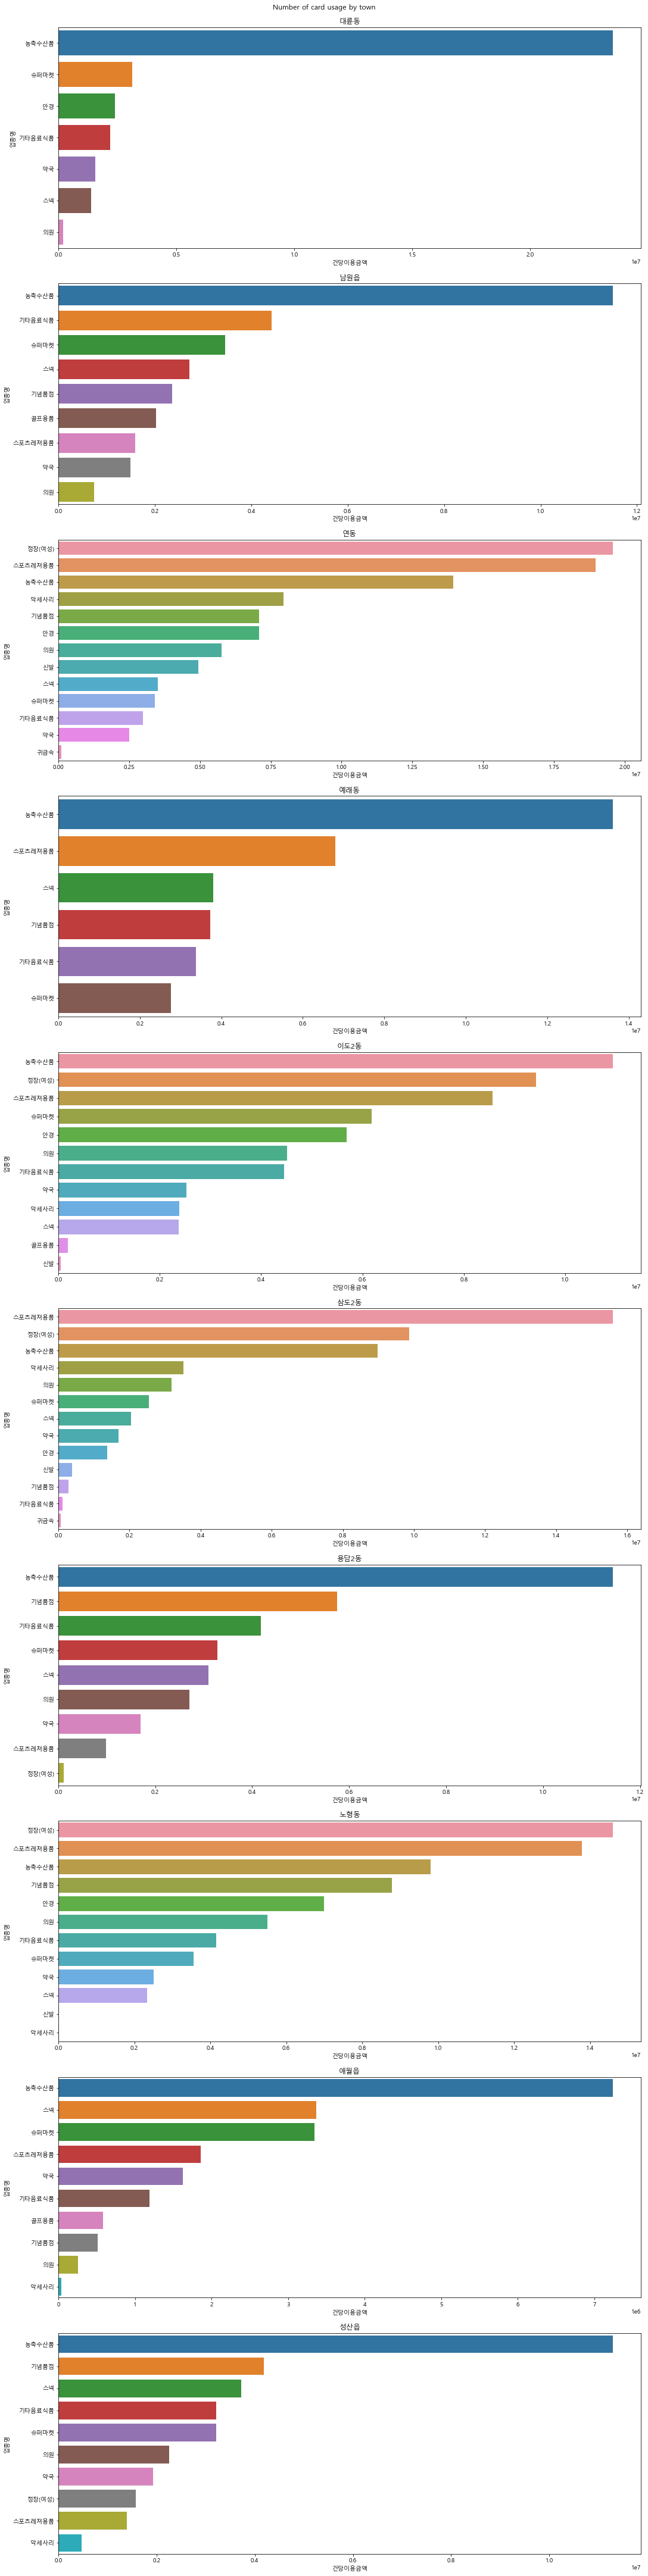

In [30]:
# 지역별로 소비된 업종 분포(카드이용건수 기준)
fig, axes = plt.subplots(nrows=len(town_in_jejudo),figsize=(15,60),constrained_layout=True)

for idx, town in enumerate(town_in_jejudo):
    sns.barplot(ax=axes[idx],x='건당이용금액',y='업종명',data=group_by_town_and_industry_df[group_by_town_and_industry_df['제주 중분류']==town].sort_values(by='건당이용금액',ascending=False))
    axes[idx].set_title(town)

plt.suptitle('Number of card usage by town')

Text(0.5, 0.98, 'Age group by town')

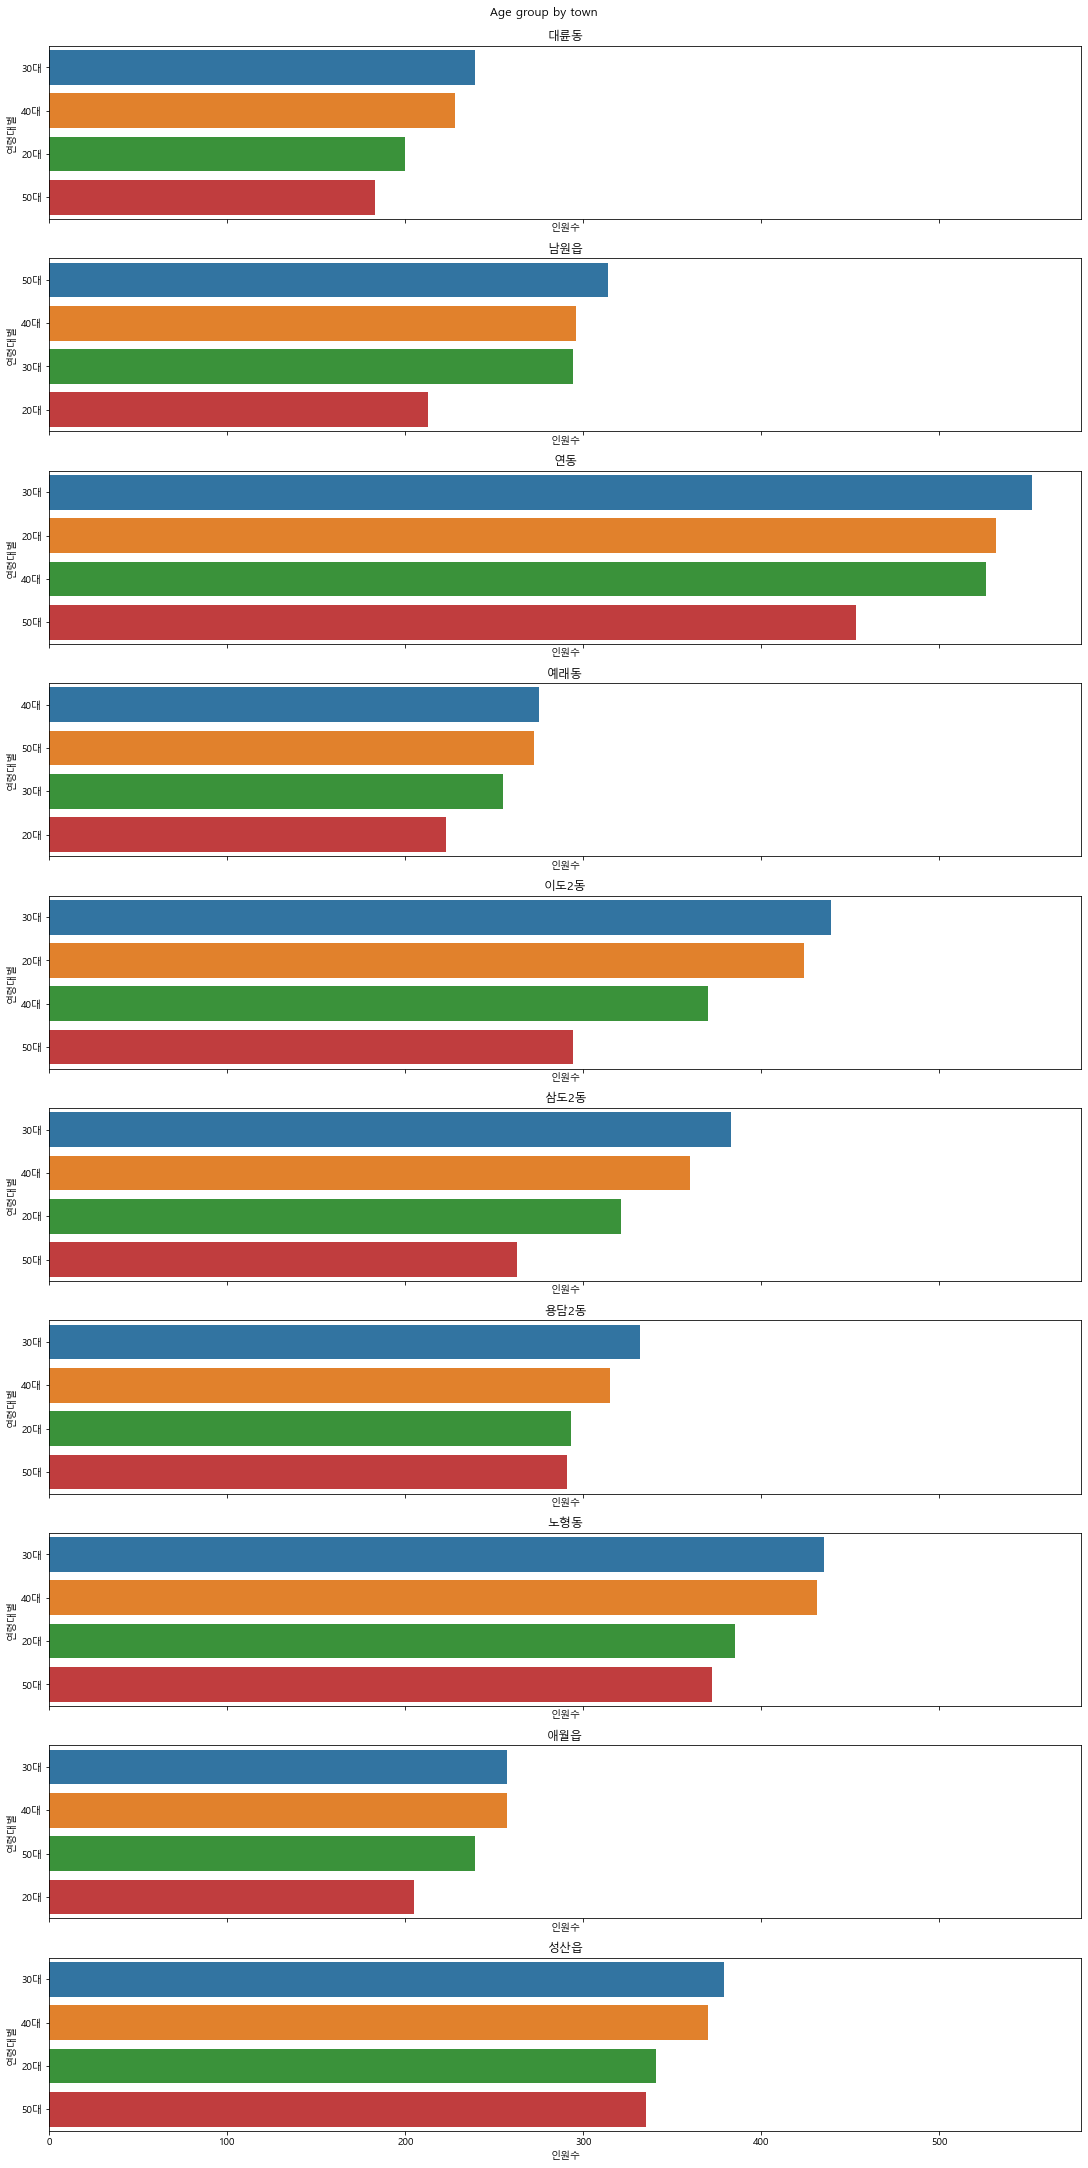

In [35]:
# 지역별로 소비된 연령대
age_grp_by_town = data.groupby(['제주 중분류','연령대별']).size()
age_grp_by_town_df = age_grp_by_town.to_frame('인원수').reset_index()
fig, axes = plt.subplots(nrows=len(town_in_jejudo),figsize=(15,30),sharex=True,constrained_layout=True)

for idx, town in enumerate(town_in_jejudo):
    sns.barplot(ax=axes[idx],x='인원수',y='연령대별',data=age_grp_by_town_df[age_grp_by_town_df['제주 중분류']==town].sort_values(by='인원수',ascending=False))
    axes[idx].set_title(town)

plt.suptitle('Age group by town')

Text(0.5, 1.0, '지역별 카드 이용 건수')

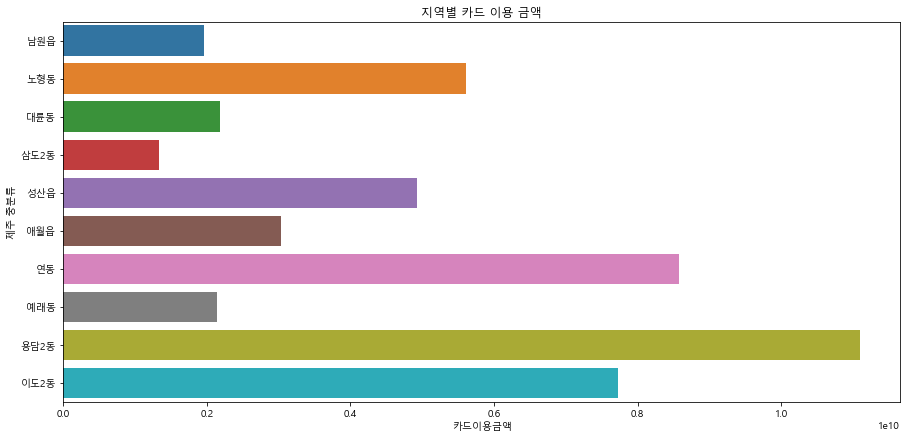

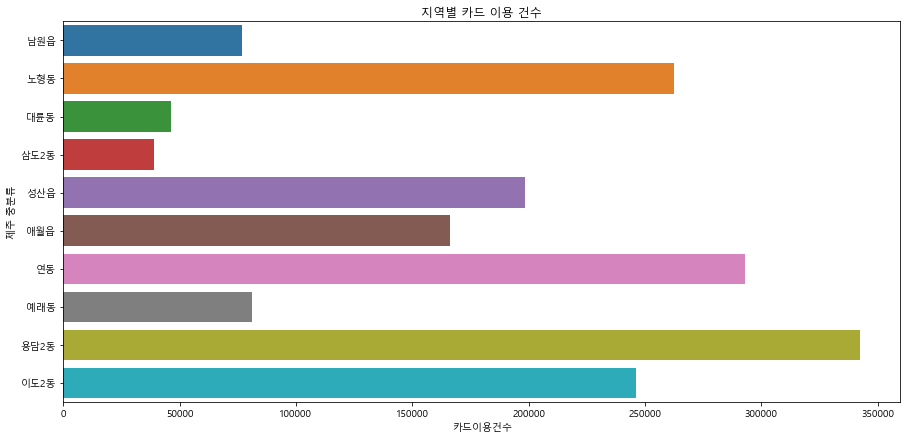

In [29]:
# 지역별 카드 이용 금액
card_usage_amount_town = data.groupby('제주 중분류')['카드이용금액'].sum()
card_usage_amount_town_df = card_usage_amount_town.to_frame('카드이용금액').reset_index()
plt.figure(figsize=(15,7))
ax= sns.barplot(x='카드이용금액',y='제주 중분류',data=card_usage_amount_town_df)
ax.set_title('지역별 카드 이용 금액')

# 지역별 카드 이용 건수
number_of_card_usage_by_town = data.groupby('제주 중분류')['카드이용건수'].sum()
number_of_card_usage_by_town_df = number_of_card_usage_by_town.to_frame('카드이용건수').reset_index()
plt.figure(figsize=(15,7))
ax= sns.barplot(x='카드이용건수',y='제주 중분류',data=number_of_card_usage_by_town_df)
ax.set_title('지역별 카드 이용 건수')

,업종명,연령대별,인원수
0,골프용품,40대,12
1,골프용품,50대,27
2,귀금속,20대,1
3,귀금속,30대,1
4,귀금속,40대,1
5,기념품점,20대,234
6,기념품점,30대,274
7,기념품점,40대,271
8,기념품점,50대,238
9,기타음료식품,20대,378


Text(0.5, 0.98, 'Age group by industry')

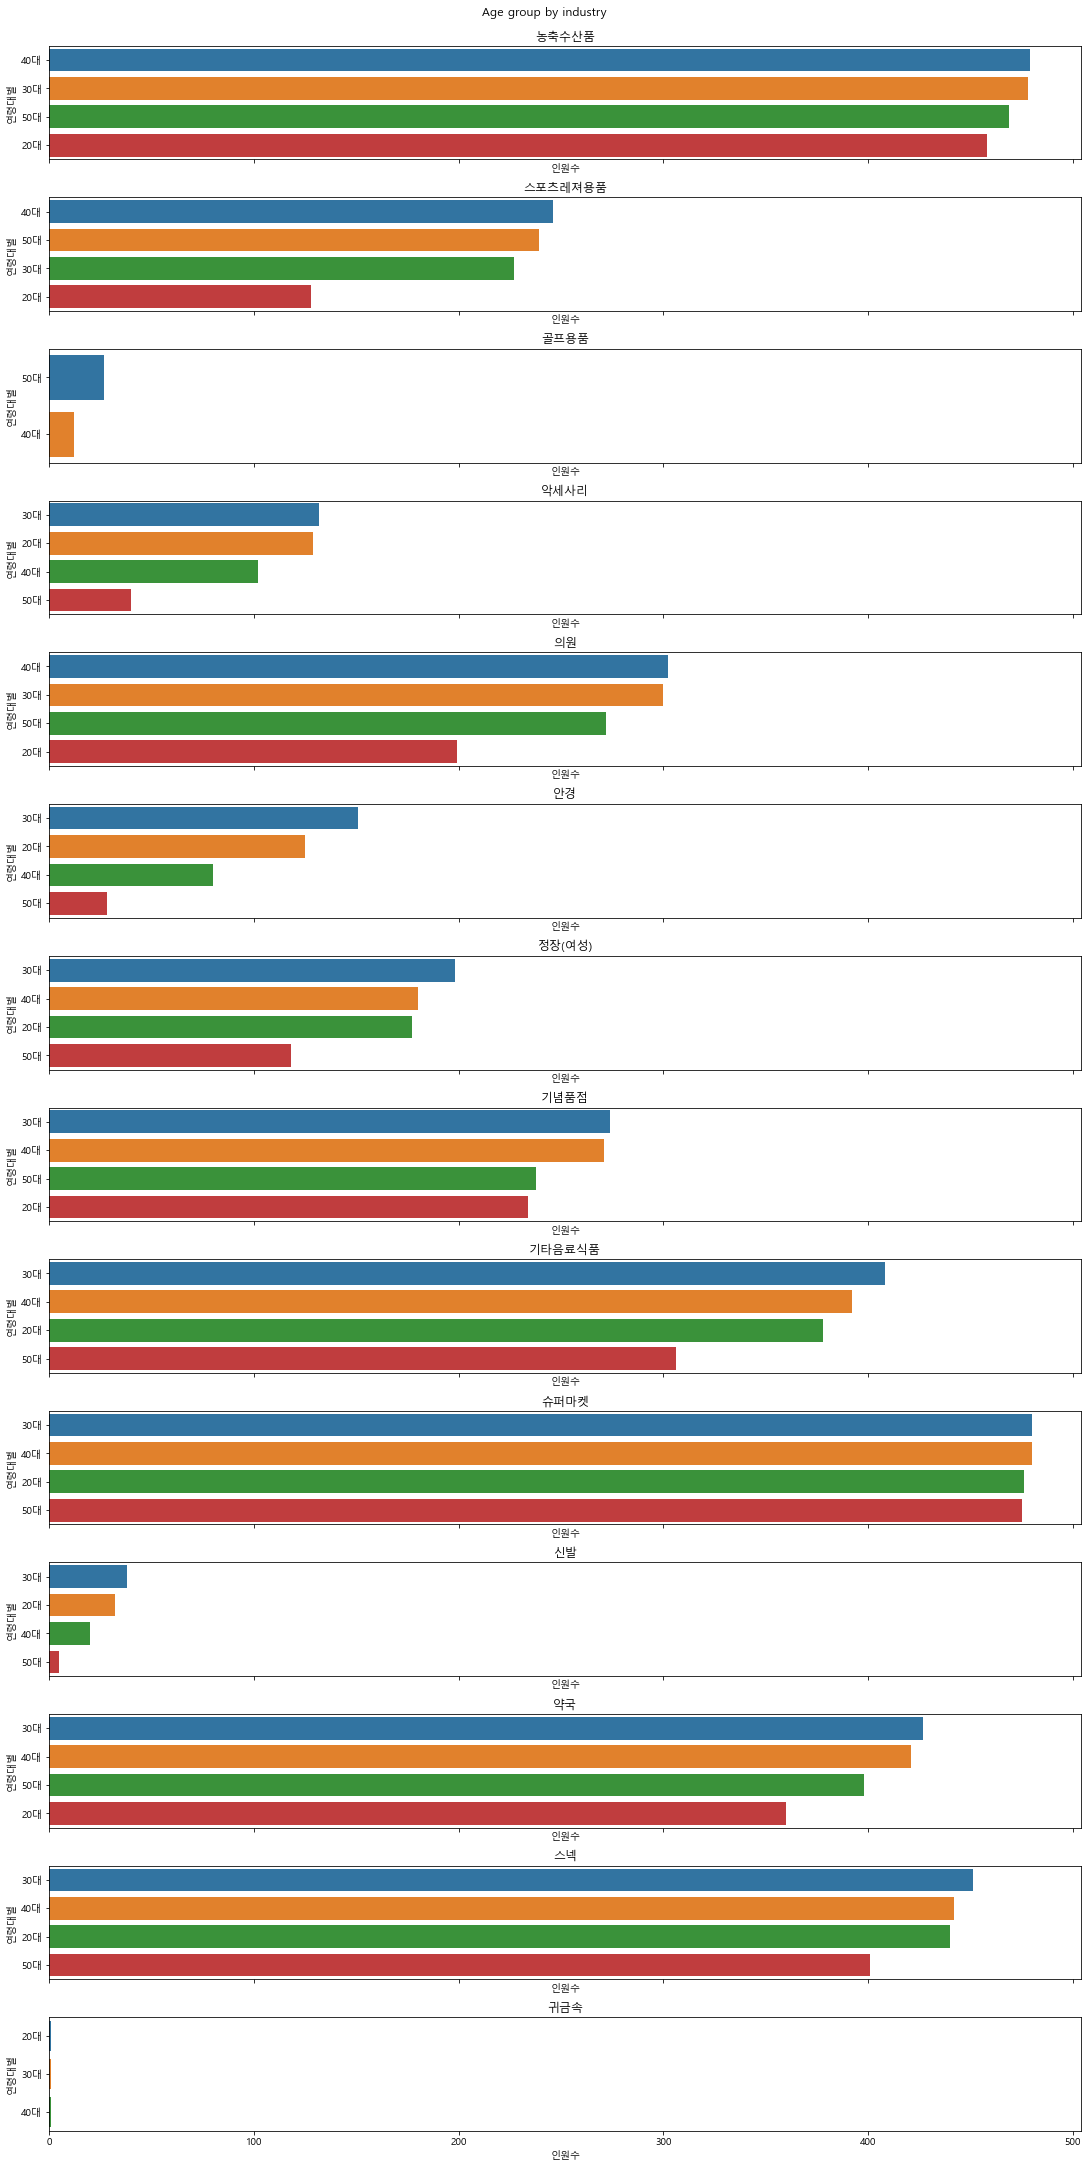

In [52]:
#업종별로 연령대별 인원수
age_grp_by_industry = data.groupby(['업종명','연령대별']).size()
age_grp_by_industry_df = age_grp_by_industry.to_frame('인원수').reset_index()
display(age_grp_by_industry_df)

fig, axes = plt.subplots(nrows=len(upjong),figsize=(15,30),sharex=True,constrained_layout=True)

for idx, industry in enumerate(upjong):
    sns.barplot(ax=axes[idx],x='인원수',y='연령대별',data=age_grp_by_industry_df[age_grp_by_industry_df['업종명']==industry].sort_values(by='인원수',ascending=False))
    axes[idx].set_title(industry)

plt.suptitle('Age group by industry')

### Feature Engineering
- 업종들 중에서 매출의 큰 비중을 차지 않는 것(또는 매출 정보가 부족한 업종)들은 삭제하도록 하자.
- 주어진 기간 동안 총 매출이 10억 미만인 업종은 삭제하자.


In [246]:
card_usage_sum = data.groupby('업종명')['카드이용금액'].sum()
card_usage_sum.sort_values(ascending=False)

업종명
농축수산품      13092560386
슈퍼 마켓      11690570213
기념품 점       7864854995
스넥          5461163557
스포츠레져용품     3413438318
정장(여성)      1652690560
의원          1646625884
약국          1552649845
기타음료식품      1338100496
안경           460747530
악세 사리        313149990
신   발         77235600
골프 용품         37213800
귀 금 속          2180100
Name: 카드이용금액, dtype: int64

In [245]:
# data가 적은 업종들 제거
drop_row = card_usage_sum.loc[card_usage_sum < 1000000000].index
result_row = set(data_df['업종명']).difference(set(drop_row))
data_df = data_df.loc[data_df['업종명'] != result_row]

#### 날짜
- 날짜를 year, month 단위로 분해하여 column을 추가하자. 
- day의 경우 모두 1이므로 추가하지 않는다.

In [148]:
data['year']= data['기준년월'].dt.year.astype(str)
data['month'] = data['기준년월'].dt.month.astype(str)

#### Encoding
- Categorical 변수들에 대해서 one-hot encoding을 적용한다.

In [225]:
# test-set과 train-set 분리
local_train = data[data['기준년월'] <= '2016-03-01'].reset_index(drop=True)
local_test = data[data['기준년월'] > '2016-03-01'].reset_index(drop=True)

display(local_train.shape)
display(local_test.shape)
# 전체 data중에서 약 22%가 test set으로 사용된다.

(10182, 9)

(2964, 9)

In [247]:
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)
lbl = LabelEncoder()

cat_cols = ['제주 대분류','제주 중분류','업종명','성별','연령대별']
for col in tqdm_notebook( cat_cols ):  
    temp_df = pd.concat([local_train[[col]], local_test[[col]]] , axis=0)
    lbl.fit(temp_df[col])
    
    local_train[col] = lbl.transform(local_train[col])
    local_test[col] = lbl.transform(local_test[col])
#     temp_df_lbl = temp_df_lbl.reshape(-1,1)
#     # 2차원으로 만들어준다.
#     ohe.fit(temp_df_lbl)
    
#     ohe.transform(local_train[col].values.reshape(-1,1)))
# #     local_test[col] = ohe.transform(local_test[col].values.reshape(-1,1))
    
    display(local_train.head())

  0%|          | 0/5 [00:00<?, ?it/s]

,기준년월,제주 대분류,제주 중분류,업종명,성별,연령대별,카드이용금액,카드이용건수,건당이용금액
0,2014-09-01,0,2,4,1,3,14434000,67,215433
1,2014-09-01,0,2,4,0,3,15119000,72,209986
2,2014-09-01,0,2,4,1,2,7609500,41,185598
3,2014-09-01,0,0,4,0,3,7092500,40,177313
4,2014-09-01,0,2,4,0,2,9098500,59,154212


,기준년월,제주 대분류,제주 중분류,업종명,성별,연령대별,카드이용금액,카드이용건수,건당이용금액
0,2014-09-01,0,2,4,1,3,14434000,67,215433
1,2014-09-01,0,2,4,0,3,15119000,72,209986
2,2014-09-01,0,2,4,1,2,7609500,41,185598
3,2014-09-01,0,0,4,0,3,7092500,40,177313
4,2014-09-01,0,2,4,0,2,9098500,59,154212


,기준년월,제주 대분류,제주 중분류,업종명,성별,연령대별,카드이용금액,카드이용건수,건당이용금액
0,2014-09-01,0,2,4,1,3,14434000,67,215433
1,2014-09-01,0,2,4,0,3,15119000,72,209986
2,2014-09-01,0,2,4,1,2,7609500,41,185598
3,2014-09-01,0,0,4,0,3,7092500,40,177313
4,2014-09-01,0,2,4,0,2,9098500,59,154212


,기준년월,제주 대분류,제주 중분류,업종명,성별,연령대별,카드이용금액,카드이용건수,건당이용금액
0,2014-09-01,0,2,4,1,3,14434000,67,215433
1,2014-09-01,0,2,4,0,3,15119000,72,209986
2,2014-09-01,0,2,4,1,2,7609500,41,185598
3,2014-09-01,0,0,4,0,3,7092500,40,177313
4,2014-09-01,0,2,4,0,2,9098500,59,154212


,기준년월,제주 대분류,제주 중분류,업종명,성별,연령대별,카드이용금액,카드이용건수,건당이용금액
0,2014-09-01,0,2,4,1,3,14434000,67,215433
1,2014-09-01,0,2,4,0,3,15119000,72,209986
2,2014-09-01,0,2,4,1,2,7609500,41,185598
3,2014-09-01,0,0,4,0,3,7092500,40,177313
4,2014-09-01,0,2,4,0,2,9098500,59,154212


In [ ]:
##### 필요없는 columns 제거
local_train = local_train.drop(['기준년월','카드이용건수','건당이용금액'],axis=1,inplace=False)
local_test = local_test.drop(['기준년월','카드이용건수','건당이용금액'],axis=1,inplace=False)

In [136]:
# Categorical variable feature들에 대해서 one-hot encoding 적용.

"""
1.먼저 data에서 필요없는 column을 제거한다
2. one-hot encoding을 적용한다.
3. test & train set을 분리한다. 
   -> 이 과정에서 시간순서로 분리하는데 문제가 발생한다.
   -> year, month로 one-hot encoding을 진행하였기 떄문에 시간순서로 test, train set을 나누기가 어렵다.

Q. 만약 둘을 먼저 나누고 one-hot encoding을 적용하려면 어떻게 해야할까?
"""

data_df = data.drop(['기준년월','카드이용건수','건당이용금액'],axis=1,inplace=False)
drop_col = card_usage_sum.loc[card_usage_sum < 1000000000].index
data.drop(drop_col)

# get_dummies 함수를 이용해서 one-hot encoding을 진행한다.
print('get_dummies 전의 특성 : \n',list(data_df.columns))
data_dummies = pd.get_dummies(data_df).reset_index(drop=True)
print('get_dummies 후의 특성 : \n',list(data_dummies.columns))

# train = data[data['year_2016','month_6','month_7','month_8']].reset_index(drop=True)
# test = data.reset_index(drop=True)
display(data_dummies.head())

get_dummies 전의 특성 : 
 ['제주 대분류', '제주 중분류', '업종명', '성별', '연령대별', '카드이용금액', 'year', 'month']
get_dummies 후의 특성 : 
 ['카드이용금액', '제주 대분류_서귀포시', '제주 대분류_제주시', '제주 중분류_남원읍', '제주 중분류_노형동', '제주 중분류_대륜동', '제주 중분류_삼도2동', '제주 중분류_성산읍', '제주 중분류_애월읍', '제주 중분류_연동', '제주 중분류_예래동', '제주 중분류_용담2동', '제주 중분류_이도2동', '업종명_골프 용품', '업종명_귀 금 속', '업종명_기념품 점', '업종명_기타음료식품', '업종명_농축수산품', '업종명_슈퍼 마켓', '업종명_스넥', '업종명_스포츠레져용품', '업종명_신   발', '업종명_악세 사리', '업종명_안경', '업종명_약국', '업종명_의원', '업종명_정장(여성)', '성별_남', '성별_여', '연령대별_20대', '연령대별_30대', '연령대별_40대', '연령대별_50대', 'year_2014', 'year_2015', 'year_2016', 'month_1', 'month_10', 'month_11', 'month_12', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9']


,카드이용금액,제주 대분류_서귀포시,제주 대분류_제주시,제주 중분류_남원읍,제주 중분류_노형동,제주 중분류_대륜동,제주 중분류_삼도2동,제주 중분류_성산읍,제주 중분류_애월읍,제주 중분류_연동,제주 중분류_예래동,제주 중분류_용담2동,제주 중분류_이도2동,업종명_골프 용품,업종명_귀 금 속,업종명_기념품 점,업종명_기타음료식품,업종명_농축수산품,업종명_슈퍼 마켓,업종명_스넥,업종명_스포츠레져용품,업종명_신 발,업종명_악세 사리,업종명_안경,업종명_약국,업종명_의원,업종명_정장(여성),성별_남,성별_여,연령대별_20대,연령대별_30대,연령대별_40대,연령대별_50대,year_2014,year_2015,year_2016,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,14434000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,15119000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,7609500,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,7092500,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,9098500,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## 3.Modeling

- 우선 간단하게 선형회귀를 돌려보자.

In [265]:
X_train, y_train = local_train.drop(['카드이용금액'],axis=1,inplace=False), local_train['카드이용금액']
X_test, y_test = local_test.drop(['카드이용금액'],axis=1,inplace=False), local_test['카드이용금액']

lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3F}'.format(mse,rmse))
print('Variance score : {0:3f}'.format(r2_score(y_test,y_preds)))
print('절편 값:',lr.intercept_)
print('회귀 계수값:',np.round(lr.coef_,1))

MSE : 45472541114184.711, RMSE : 6743333.086
Variance score : 0.115237
절편 값: 3299883.733235509
회귀 계수값: [1669796.   349185.8 -475284.1 -315550.9  562772. ]


In [268]:
# 모델에 쓰일 parameter 정의하기
n_splits= 5
NUM_BOOST_ROUND = 100000
SEED = 1993  
lgbm_param = {'objective':'rmse',
              'boosting_type': 'gbdt',
              'random_state':1993,   
              'learning_rate':0.3,
              'subsample':0.7,
              'tree_learner': 'serial',
              'colsample_bytree':0.78,
              'early_stopping_rounds':50,
              'subsample_freq': 1,
              'reg_lambda':7,
              'reg_alpha': 5,
              'num_leaves': 96,
              'verbose':-1,
              'seed' : SEED
            }

In [ ]:
# 각 모델별로 어떠한 모델이 가장 성능이 좋은지 확인해보자

# 각 모델에 대한 oof 정의
ridge_oof_train = np.zeros((y_train.shape[0]))
lasso_oof_train = np.zeros((y_train.shape[0]))
dt_oof_train = np.zeros((y_train.shape[0]))
rf_oof_train = np.zeros((y_train.shape[0]))
lgbm_oof_train = np.zeros((y_train.shape[0]))
svc_oof_train = np.zeros((y_train.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = X_train, y = y_train ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train_f , y_train_f = X_train.iloc[trn_ind], y_train[trn_ind]
    X_valid , y_valid = X_train.iloc[val_ind], y_train[val_ind]
    
    # (1) Ridge
    print("---TRAINING RIDGE---")
    ridge = Ridge(random_state = 1993)
    
    ridge.fit(X_train_f, y_train_f)
    
    ridge_valid_pred = ridge.predict(X_valid)
    ridge_oof_train[val_ind] = ridge_valid_pred
    
    # (2) Lasso
    print("---TRAINING LASSO---")
    lasso = Lasso(random_state = 1993)
    
    lasso.fit(X_train_f, y_train_f)
    
    lasso_valid_pred = lasso.predict(X_valid)
    lasso_oof_train[val_ind] = lasso_valid_pred
    
    # (3) Decision Tree
    print("---TRAINING DECISION TREE---")
    dt = DecisionTreeRegressor(random_state=231)
    
    dt.fit(X_train_f, y_train_f)
    
    dt_valid_pred = dt.predict(X_valid)
    dt_oof_train[val_ind] = dt_valid_pred
    
    
    # (4) Random Forest
    print("---TRAINING RANDOM FOREST---")
    rf = RandomForestRegressor(random_state=231, n_estimators=20 )
    
    rf.fit(X_train_f, y_train_f)
    
    rf_valid_pred = rf.predict(X_valid)
    rf_oof_train[val_ind] = rf_valid_pred
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train_f, y_train_f)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       verbose_eval= 0)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    
    # (6) SVM
    print("---TRAINING SUPPORT VECTOR MACHINE---")
    svc = SVC(C=1,kernel='linear')
    svc.fit(X_train_f, y_train_f)
    
    svc_valid_pred = svc.predict(X_valid)
    svc_oof_train[val_ind] = svc_valid_pred
    print('='*80)
    
print(f"<Ridge> OVERALL RMSE         : {sqrt( mean_squared_error( y_train, ridge_oof_train ) )}")
print(f"<Lasso> OVERALL RMSE         : {sqrt( mean_squared_error( y_train, lasso_oof_train ) )}")
print(f"<Decision-Tree> OVERALL RMSE : {sqrt( mean_squared_error( y_train, dt_oof_train ) )}")
print(f"<Random-Forest> OVERALL RMSE : {sqrt( mean_squared_error( y_train, rf_oof_train ) )}")
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( y_train, lgbm_oof_train ) )}")
print(f"<SVC> OVERALL RMSE     : {sqrt( mean_squared_error( y_train, svc_oof_train ) )}")

In [271]:
def get_top_error_data(y_test,pred,n_tops=5):
    result_df = pd.DataFrame(y_test.values,columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count']-result_df['predicted_count'])
    
    print(result_df.sort_values('diff',ascending=False)[:n_tops])

get_top_error_data(y_test,y_preds,n_tops=5)

      real_count  predicted_count        diff
2607    64277700        6497047.0  57780653.0
2023    61323000        6497047.0  54825953.0
2590    59618300        7059819.0  52558481.0
2551    56032970        6298704.0  49734266.0
2575    56079400        7375370.0  48704030.0


<AxesSubplot:>

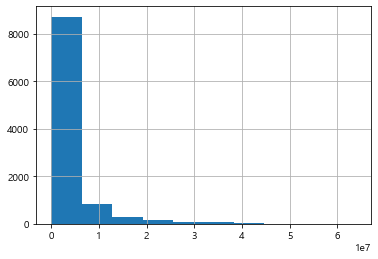

In [251]:
y_train.hist()

<AxesSubplot:>

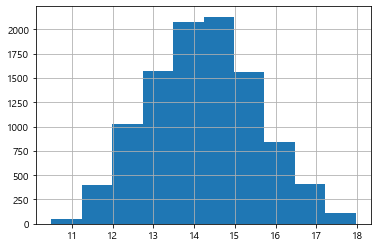

In [252]:
y_log_transform = np.log1p(y_train)
y_log_transform.hist()

<AxesSubplot:>

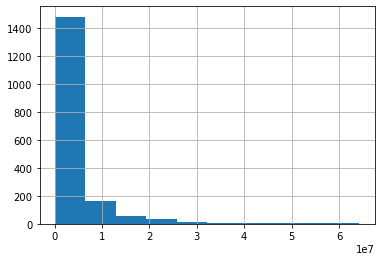

In [65]:
y_test.hist()

<AxesSubplot:>

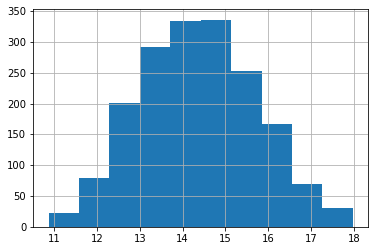

In [66]:
y_log_transform = np.log1p(y_test)
y_log_transform.hist()

In [254]:
X_train, y_train = local_train.drop(['카드이용금액'],axis=1,inplace=False), np.log1p(local_train['카드이용금액'])
X_test, y_test = local_test.drop(['카드이용금액'],axis=1,inplace=False), np.log1p(local_test['카드이용금액'])

lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(y_preds)

mse = mean_squared_error(y_test_exp, pred_exp)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3F}'.format(mse,rmse))
print('Variance score : {0:3f}'.format(r2_score(y_test,y_preds)))
print('절편 값:',lr.intercept_)
print('회귀 계수값:',np.round(lr.coef_,1))

MSE : 53687420520631.148, RMSE : 7327170.021
Variance score : 0.123793
절편 값: 14.280106879134337
회귀 계수값: [ 0.5  0.1 -0.1 -0.   0.1]


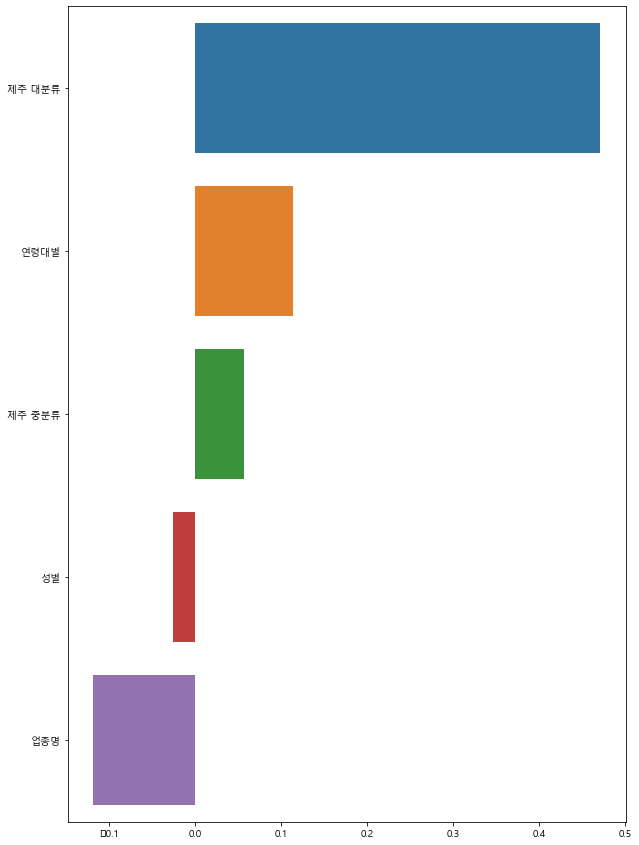

In [255]:
coef = pd.Series(lr.coef_,index= X_train.columns)
coef_sort = coef.sort_values(ascending=False)

plt.figure(figsize=(10,15))
ax = sns.barplot(x=coef_sort.values,y=coef_sort.index)

In [256]:
X_train, y_train = local_train.drop(['카드이용금액'],axis=1,inplace=False), np.log1p(local_train['카드이용금액'])
X_test, y_test = local_test.drop(['카드이용금액'],axis=1,inplace=False), np.log1p(local_test['카드이용금액'])

lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)

y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(y_preds)

mse = mean_squared_error(y_test_exp, pred_exp)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3F}'.format(mse,rmse))
print('Variance score : {0:3f}'.format(r2_score(y_test,y_preds)))
print('절편 값:',lr.intercept_)
print('회귀 계수값:',np.round(lr.coef_,1))

MSE : 53687420520631.148, RMSE : 7327170.021
Variance score : 0.123793
절편 값: 14.280106879134337
회귀 계수값: [ 0.5  0.1 -0.1 -0.   0.1]
